临床模型，sigmoid_SVM最优  
delta影像组学模型 ，RF 最优  
深度学习模型 为transformer架构时序模型，CNN结构用于特征提取，将DL模型的输出记录为DL-sign  
联合模型  DL-sign、长轴直径（mm）、边缘三个特征作为模型输入（该三个特征经过单因素、多因素p小于0.05筛选），LR算法最优  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import joblib

In [4]:

path1=r'D:\pixelmedAI\function_pm\note4-指标汇总\run\clinic\results\pred'
path2=r'D:\pixelmedAI\function_pm\note4-指标汇总\run\Rad\results\pred'
path3=r'D:\pixelmedAI\function_pm\note4-指标汇总\run\DL_clinic\results\pred'
path4='/Users/y2k/workstation_y2k/127lungnode/run/DL_clinic/results/pred'

# 读取数据
data = {
    'Clinic': [f'{path1}/x_train.csv',
               
                  f'{path1}/x_test.csv',
                    f'{path1}/y_train.csv',
              
                     f'{path1}/y_test.csv'
                  ],
    'Rad': [f'{path2}/x_train.csv',
               
                  f'{path2}/x_test.csv',
                    f'{path2}/y_train.csv',
             
                     f'{path2}/y_test.csv'],

    'Combine': [f'{path3}/x_train.csv',
               
                  f'{path3}/x_test.csv',
                    f'{path3}/y_train.csv',
        
                     f'{path3}/y_test.csv'],
}

# 加载模型和预测
models = {
    'Clinic': joblib.load(filename=r"D:\pixelmedAI\function_pm\note4-指标汇总\run\clinic\results\model_weight\sigmoid_SVM.pkl"),
    'Rad': joblib.load(filename=r"D:\pixelmedAI\function_pm\note4-指标汇总\run\Rad\results\model_weight\RF.pkl"),
    'Combine': joblib.load(filename=r"D:\pixelmedAI\function_pm\note4-指标汇总\run\DL_clinic\results\model_weight\LR.pkl"),
}

pred_scores = {}
for key, path_list in data.items():
    pred_scores[key] = {
        'train': models[key].predict_proba(pd.read_csv(path_list[0]).iloc[:,:]),# 注意由于保存文件时，index=true，所以[:,1:]，后面会全部修正[:,:]
        'test': models[key].predict_proba(pd.read_csv(path_list[1]).iloc[:,:]),
    }
label_dict = {}
for key, path_list in data.items():
    label_dict[key] = {
        'train': pd.read_csv(path_list[2])['label'],
        'test': pd.read_csv(path_list[3])['label'],
    }

predictions={}
for key, path_list in data.items():
    predictions[key] = {
        'train': models[key].predict(pd.read_csv(path_list[0]).iloc[:,:]),
        'test': models[key].predict(pd.read_csv(path_list[1]).iloc[:,:]),
        
    }

In [5]:
pred_scores['DL']={
    'train': np.array(pd.read_csv(r"D:\pixelmedAI\function_pm\note4-指标汇总\run\DL\train_metrics_epoch_1.csv")[['probability_1','probability_1']]),
    
    'test': np.array(pd.read_csv(r"D:\pixelmedAI\function_pm\note4-指标汇总\run\DL\test_metrics_epoch_1.csv")[['probability_1','probability_1']])
}

label_dict['DL']={
    'train': np.array(pd.read_csv((r"D:\pixelmedAI\function_pm\note4-指标汇总\run\DL\train_metrics_epoch_1.csv"))['target']),
   
    'test': np.array(pd.read_csv(r"D:\pixelmedAI\function_pm\note4-指标汇总\run\DL\test_metrics_epoch_1.csv")['target'])
}

## 训练集校准曲线

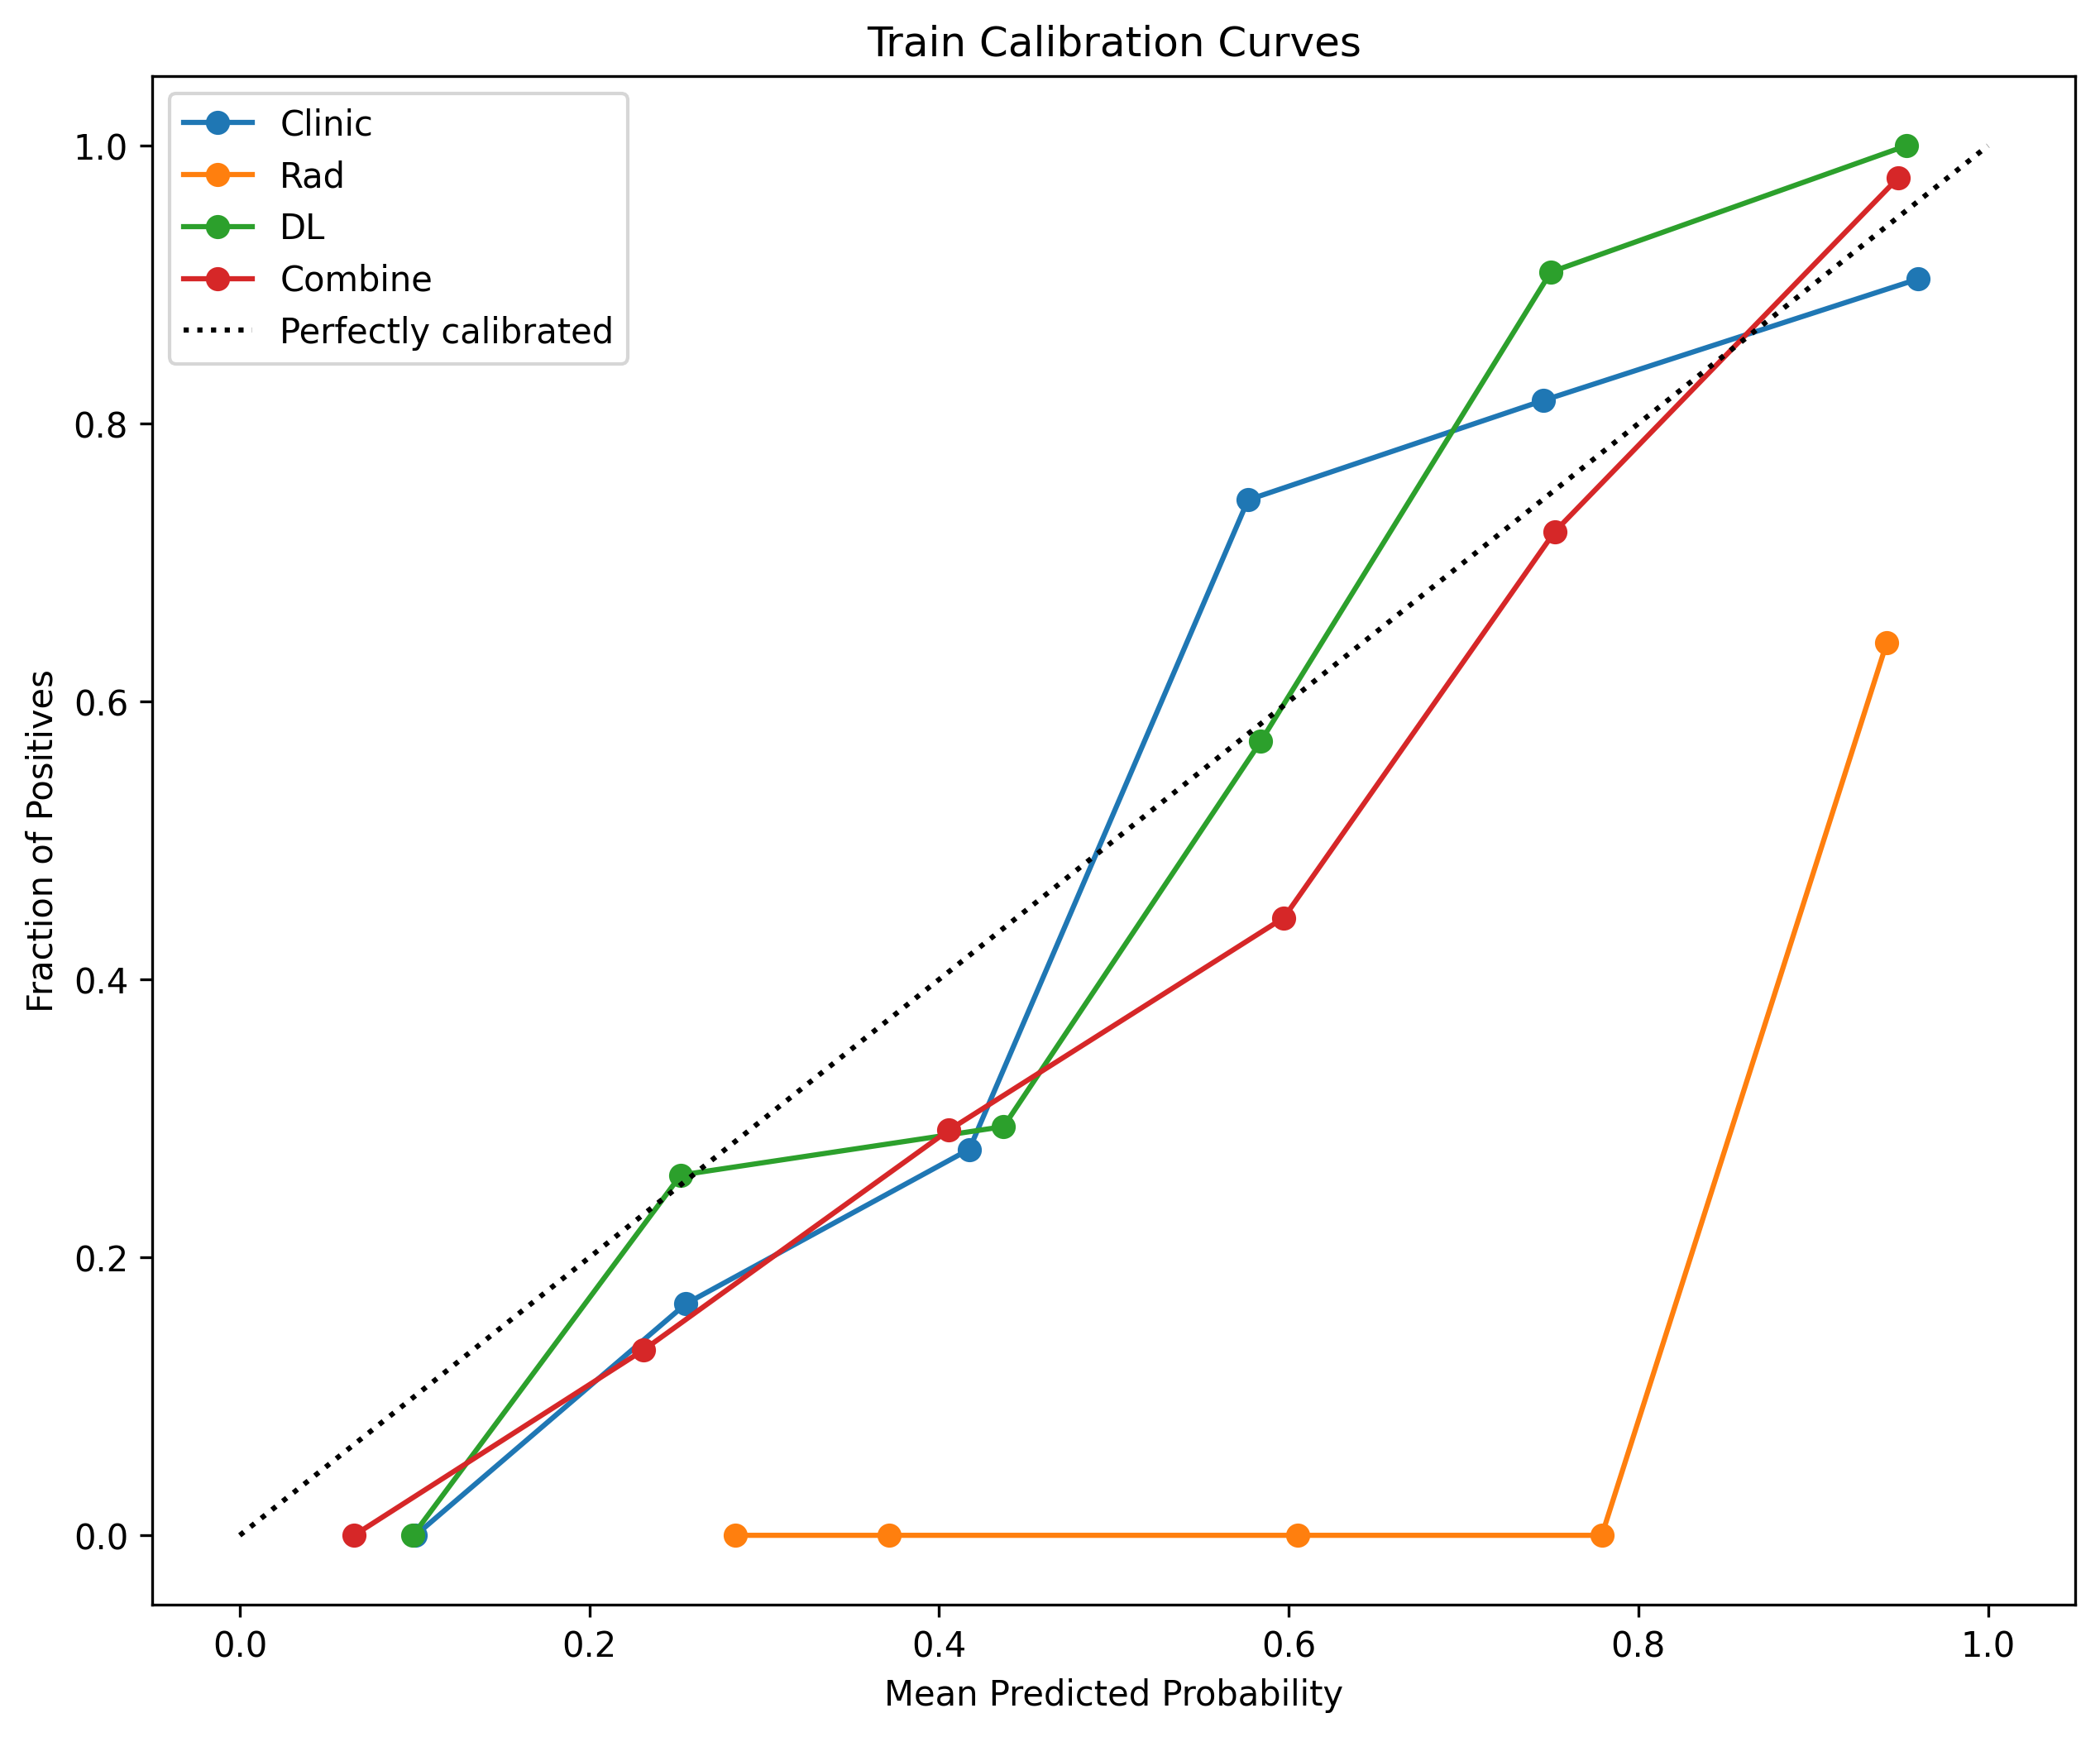

In [6]:
from pixelmed_calc.medical_imaging.RadiologyComponents.components1 import HosmerLemeshow
from pixelmed_calc.medical_imaging.Ploting.plot_metric import plot_calibration_curves
model_names = ['Clinic', 'Rad','DL','Combine']

pred_scores_train = [pred_scores[model]['train'][:,1] for model in model_names]
y_test_arrays = [label_dict[model]['train'] for model in model_names]

plot_calibration_curves(y_test_arrays,pred_scores_train,models=model_names,title='Train')
plt.savefig('results/calibration_curve_train.svg')

In [7]:


# 定义要进行hosmer_lemeshow_test的数据标签列表
label_groups =model_names = ['Clinic', 'Rad','DL','Combine']
hosmer_test_results = {}

for group in label_groups:
    test_labels = label_dict[group]['train']
    test_scores = pred_scores[group]['train'][:,1]


    hl_result_train = HosmerLemeshow(test_scores, test_labels,Q=5)
    print(f'{group} train:\n{hl_result_train}')




Clinic train:
   df     Chi2  p - value
0   3  0.81548    0.84576
Rad train:
   df      Chi2  p - value
0   3  167.1101        0.0
DL train:
   df     Chi2  p - value
0   3  0.86387    0.83414
Combine train:
   df     Chi2  p - value
0   3  2.23273    0.52553


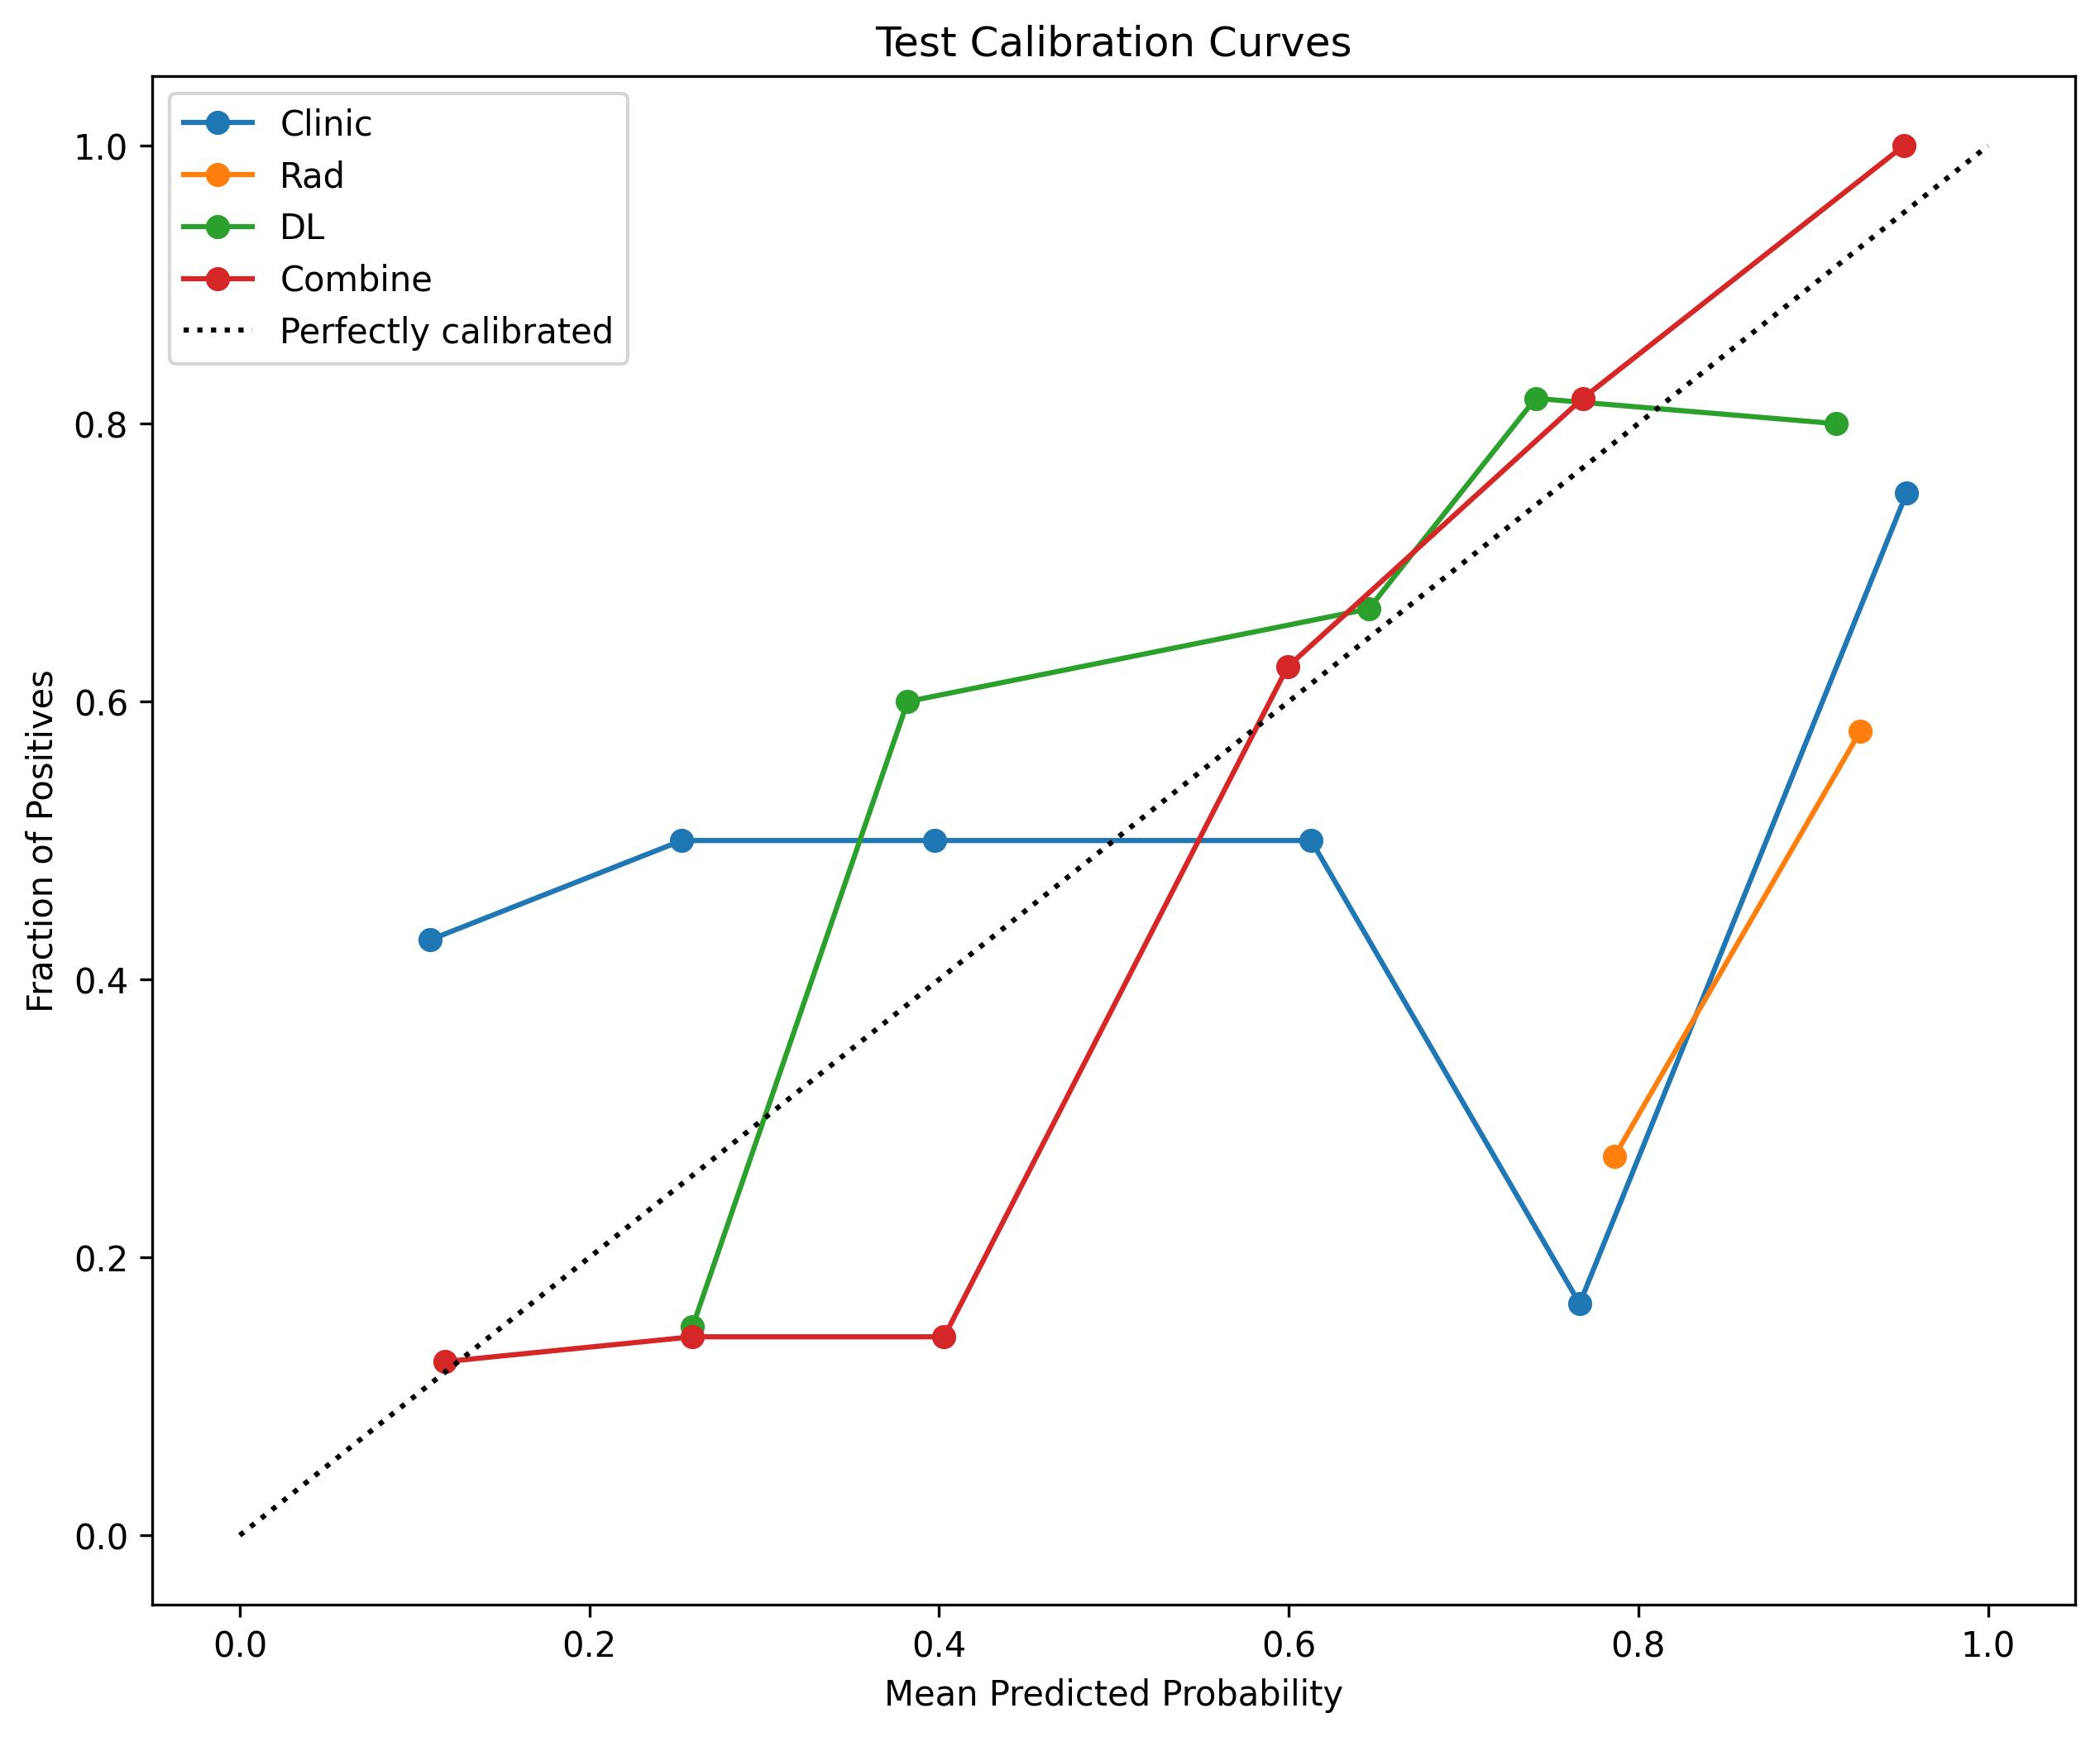

In [8]:
model_names = ['Clinic', 'Rad','DL','Combine']

pred_scores_train = [pred_scores[model]['test'][:,1] for model in model_names]
y_test_arrays = [label_dict[model]['test'] for model in model_names]

plot_calibration_curves(y_test_arrays,pred_scores_train,models=model_names,title='Test')
plt.savefig('results/calibration_curve_test.svg')

In [9]:


# 定义要进行hosmer_lemeshow_test的数据标签列表
label_groups =model_names = ['Clinic', 'Rad','DL','Combine']
hosmer_test_results = {}

for group in label_groups:
    test_labels = label_dict[group]['test']
    test_scores = pred_scores[group]['test'][:,1]


    hl_result_train = HosmerLemeshow(test_scores, test_labels,Q=5)
    print(f'{group} test:\n{hl_result_train}')




Clinic test:
   df     Chi2  p - value
0   3  0.08988    0.99302
Rad test:
   df      Chi2  p - value
0   3  29.11044        0.0
DL test:
   df    Chi2  p - value
0   3  0.1404    0.98658
Combine test:
   df     Chi2  p - value
0   3  0.16775    0.98262


<function matplotlib.pyplot.close(fig=None)>

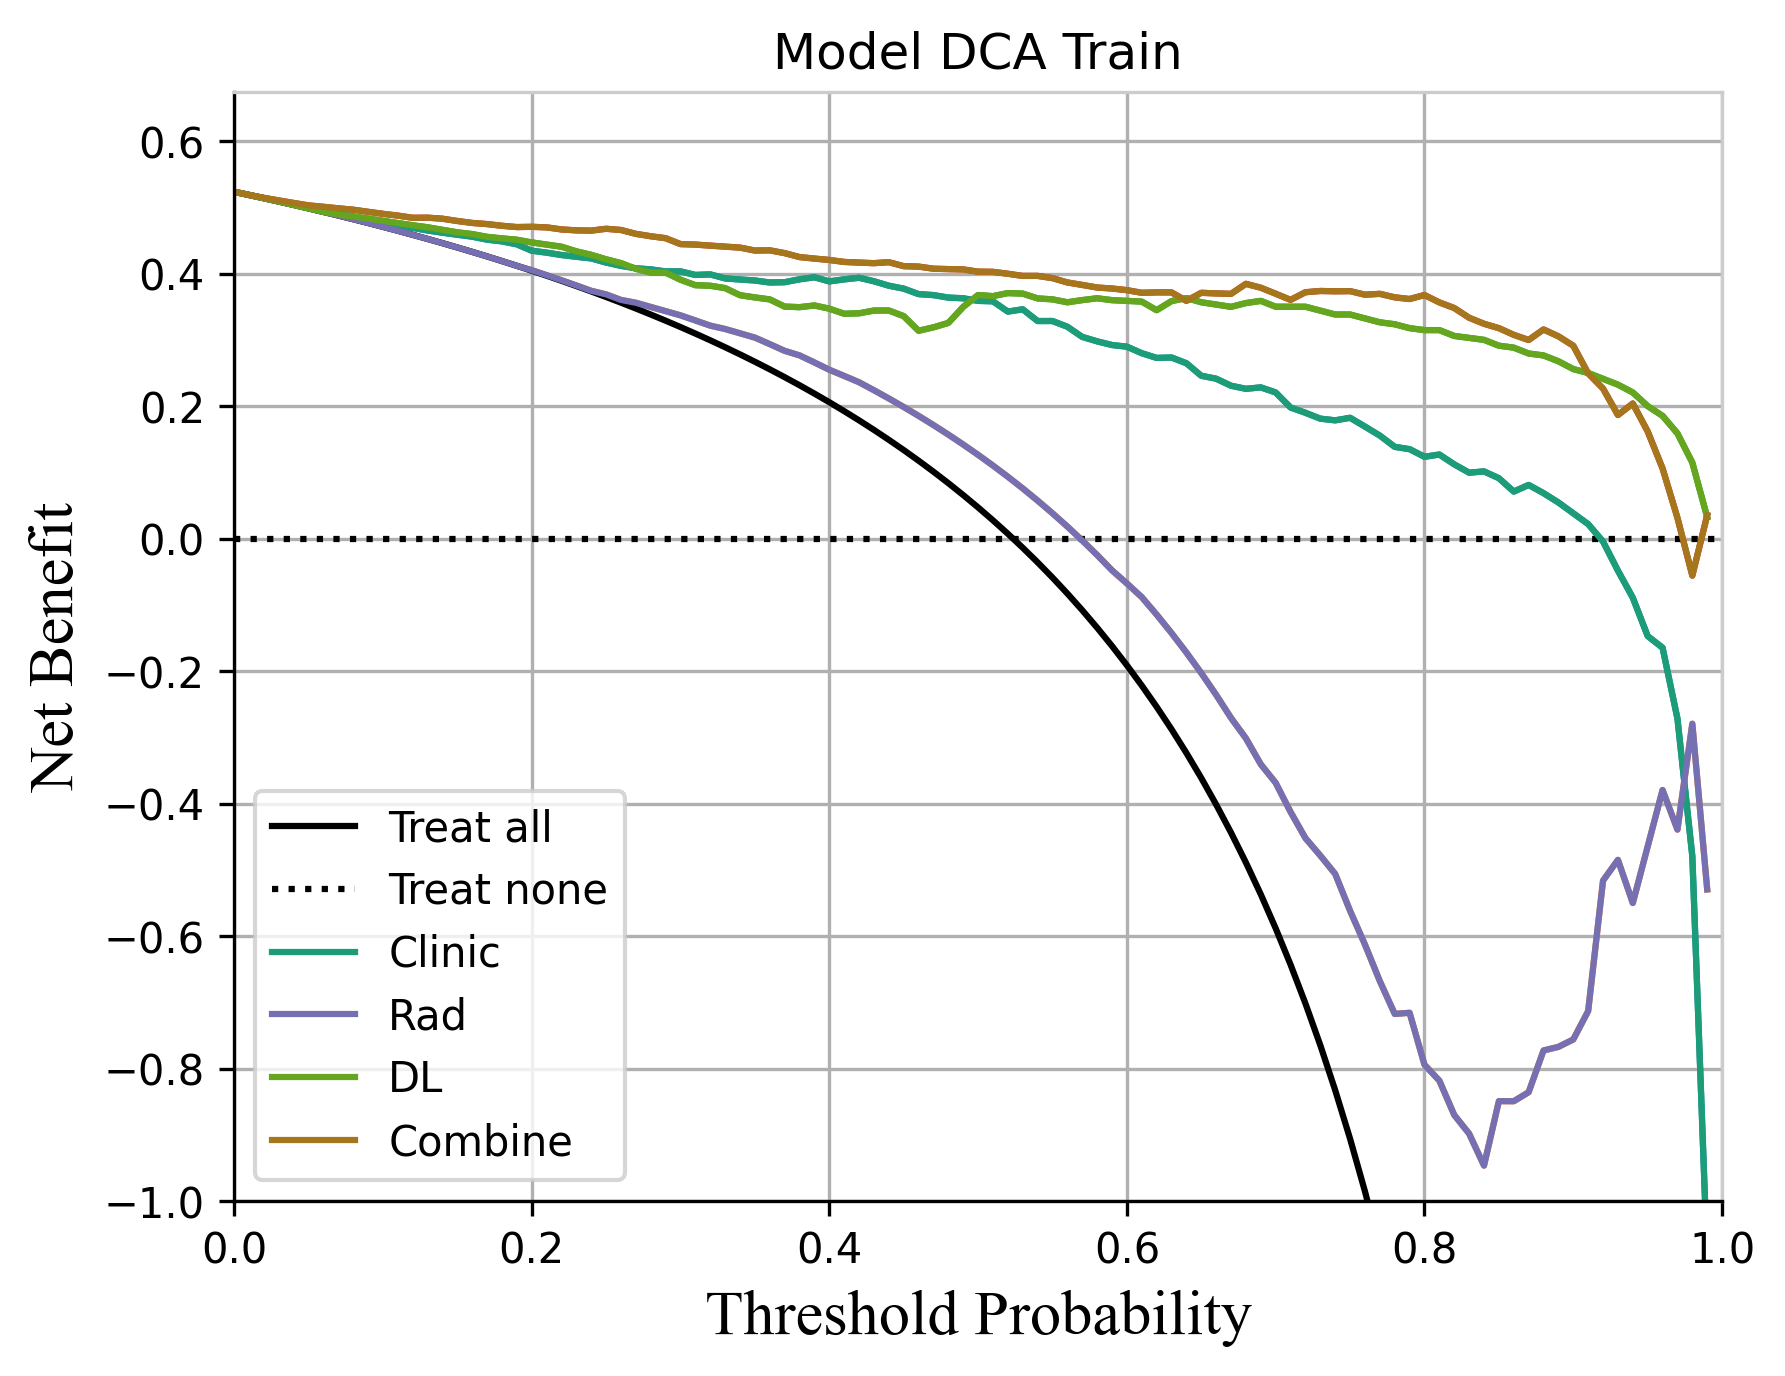

In [10]:
from pixelmed_calc.medical_imaging.Ploting.plot_metric import plot_DCA_all

labels = model_names 

y_label_list_train = [np.array(label_dict[label]['train']) for label in labels]
predlabel_list_train = [pred_scores[label]['train'][:, 1] for label in labels]

# Now call plot_DCA function with the simplified lists
plot_DCA_all(predlabel_list_train, y_label_list_train, labels=labels, title='Model DCA Train', label_loc='lower left',y_min=-1)
plt.savefig('results/DAC-train.svg')
plt.close

<function matplotlib.pyplot.close(fig=None)>

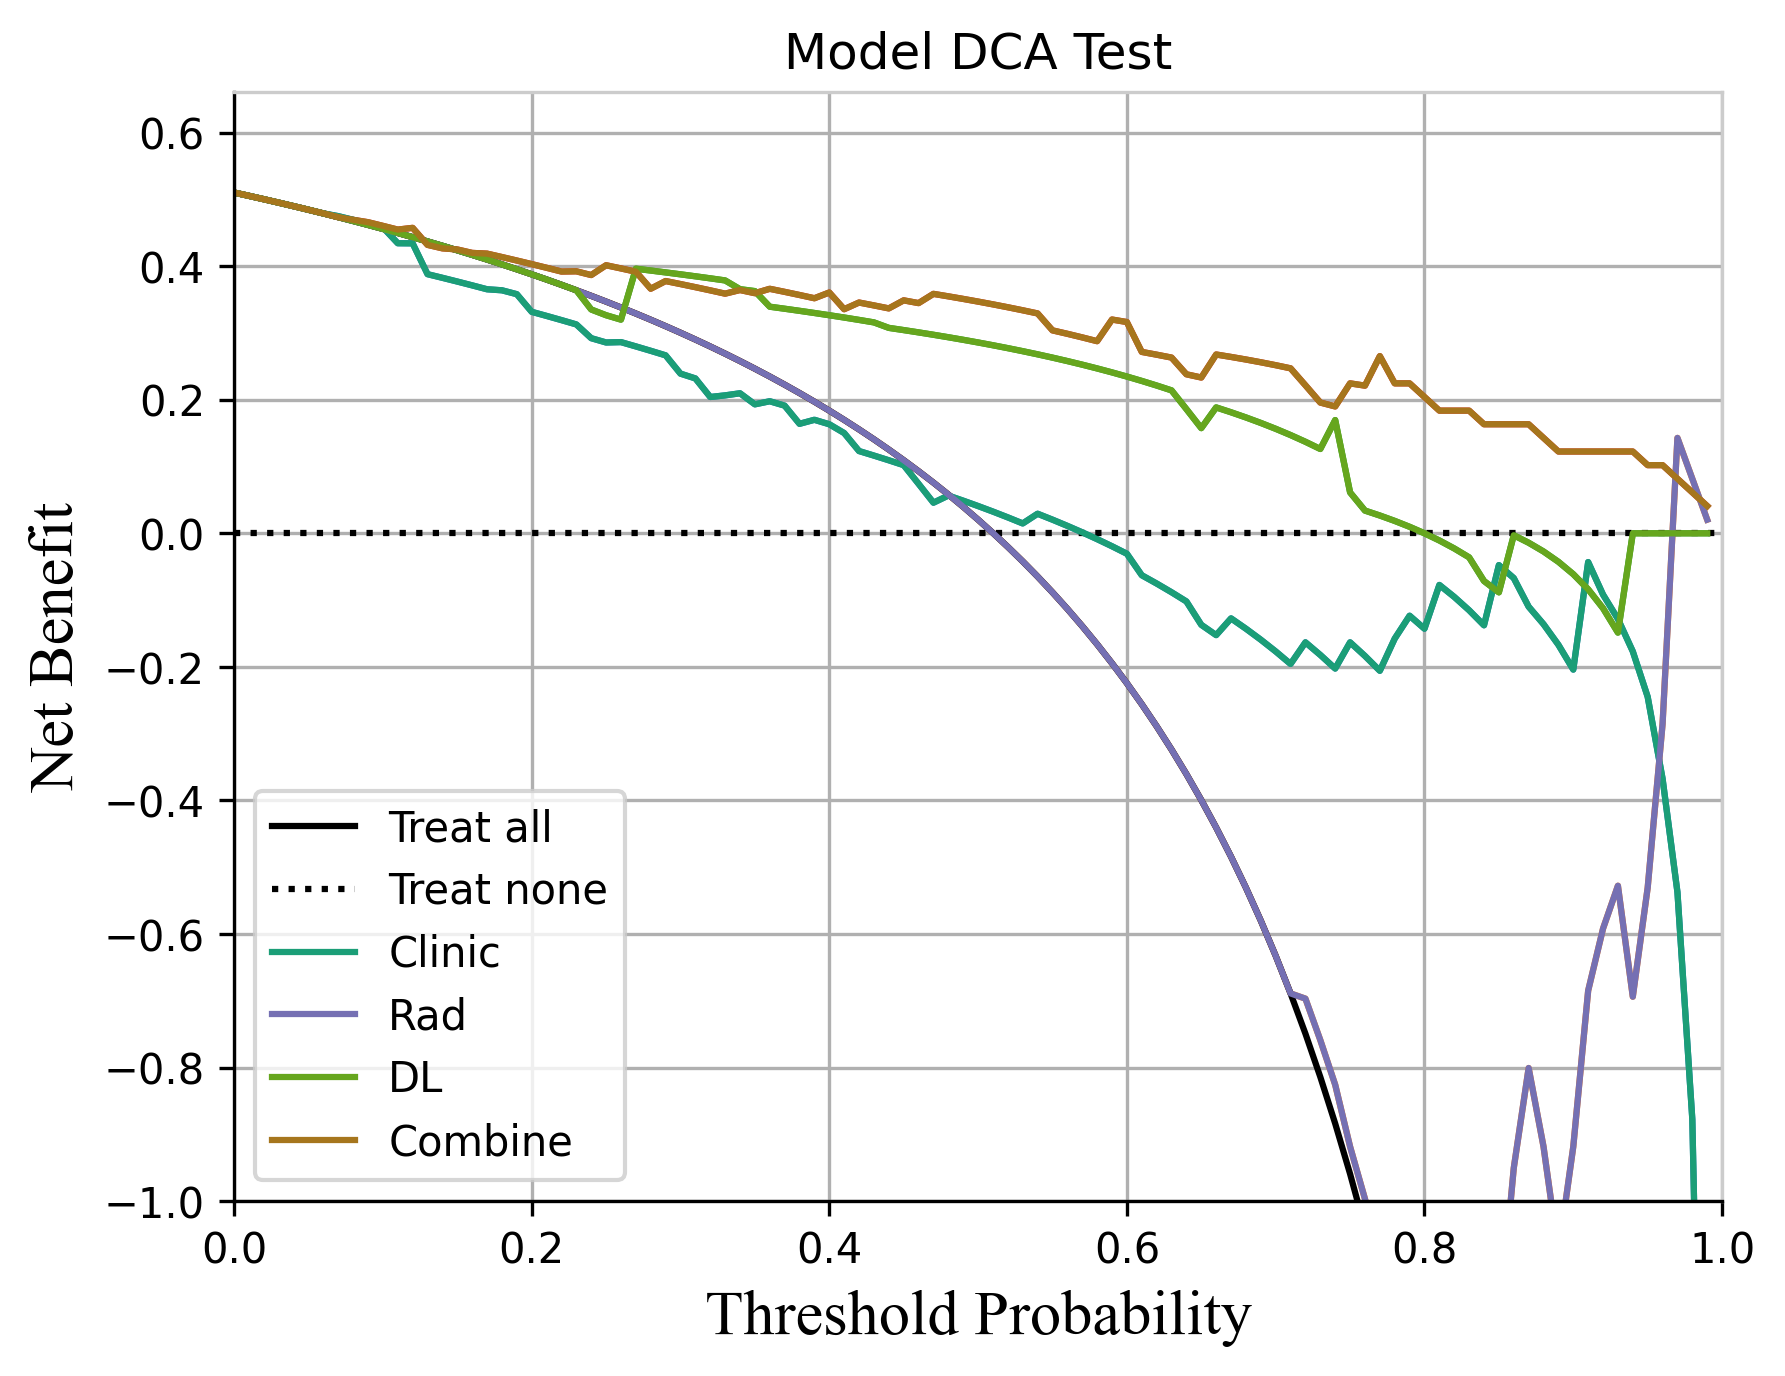

In [11]:


labels = model_names 


y_label_list_train = [np.array(label_dict[label]['test']) for label in labels]
predlabel_list_train = [pred_scores[label]['test'][:, 1] for label in labels]

# Now call plot_DCA function with the simplified lists
plot_DCA_all(predlabel_list_train, y_label_list_train, labels=labels, title='Model DCA Test', label_loc='lower left',y_min=-1)
plt.savefig('results/DAC-test.svg')
plt.close

训练集 ROC

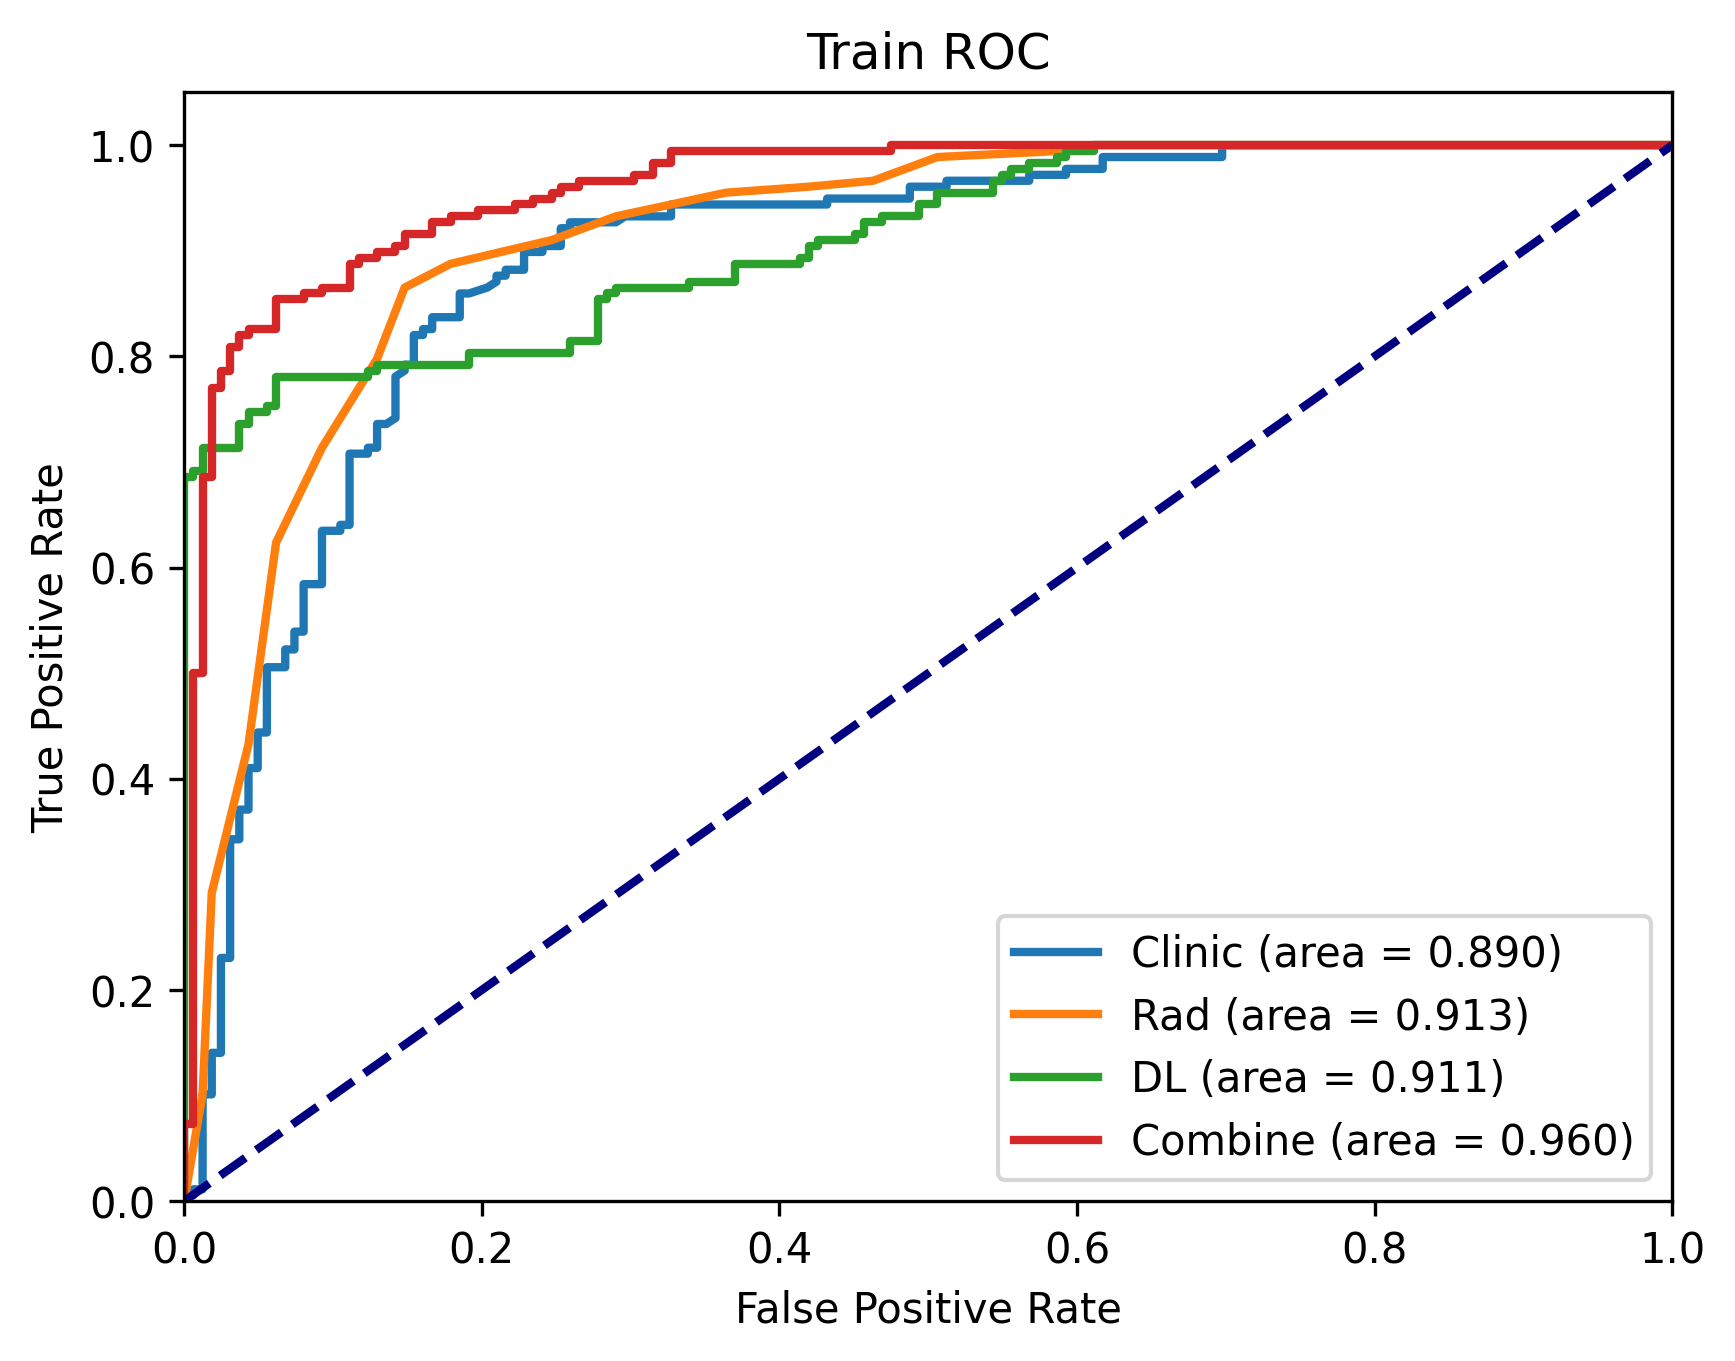

In [12]:
from pixelmed_calc.medical_imaging.Ploting.plot_metric import plot_multiple_ROCs
pred_scores_train = [pred_scores[model]['train'][:,1] for model in model_names]
y_test_arrays = [np.array(label_dict[model]['train']) for model in model_names]


plot_multiple_ROCs(y_test_arrays,pred_scores_train,models=model_names,title='Train ROC')
plt.savefig(f'results/train_roc.svg')
plt.show()



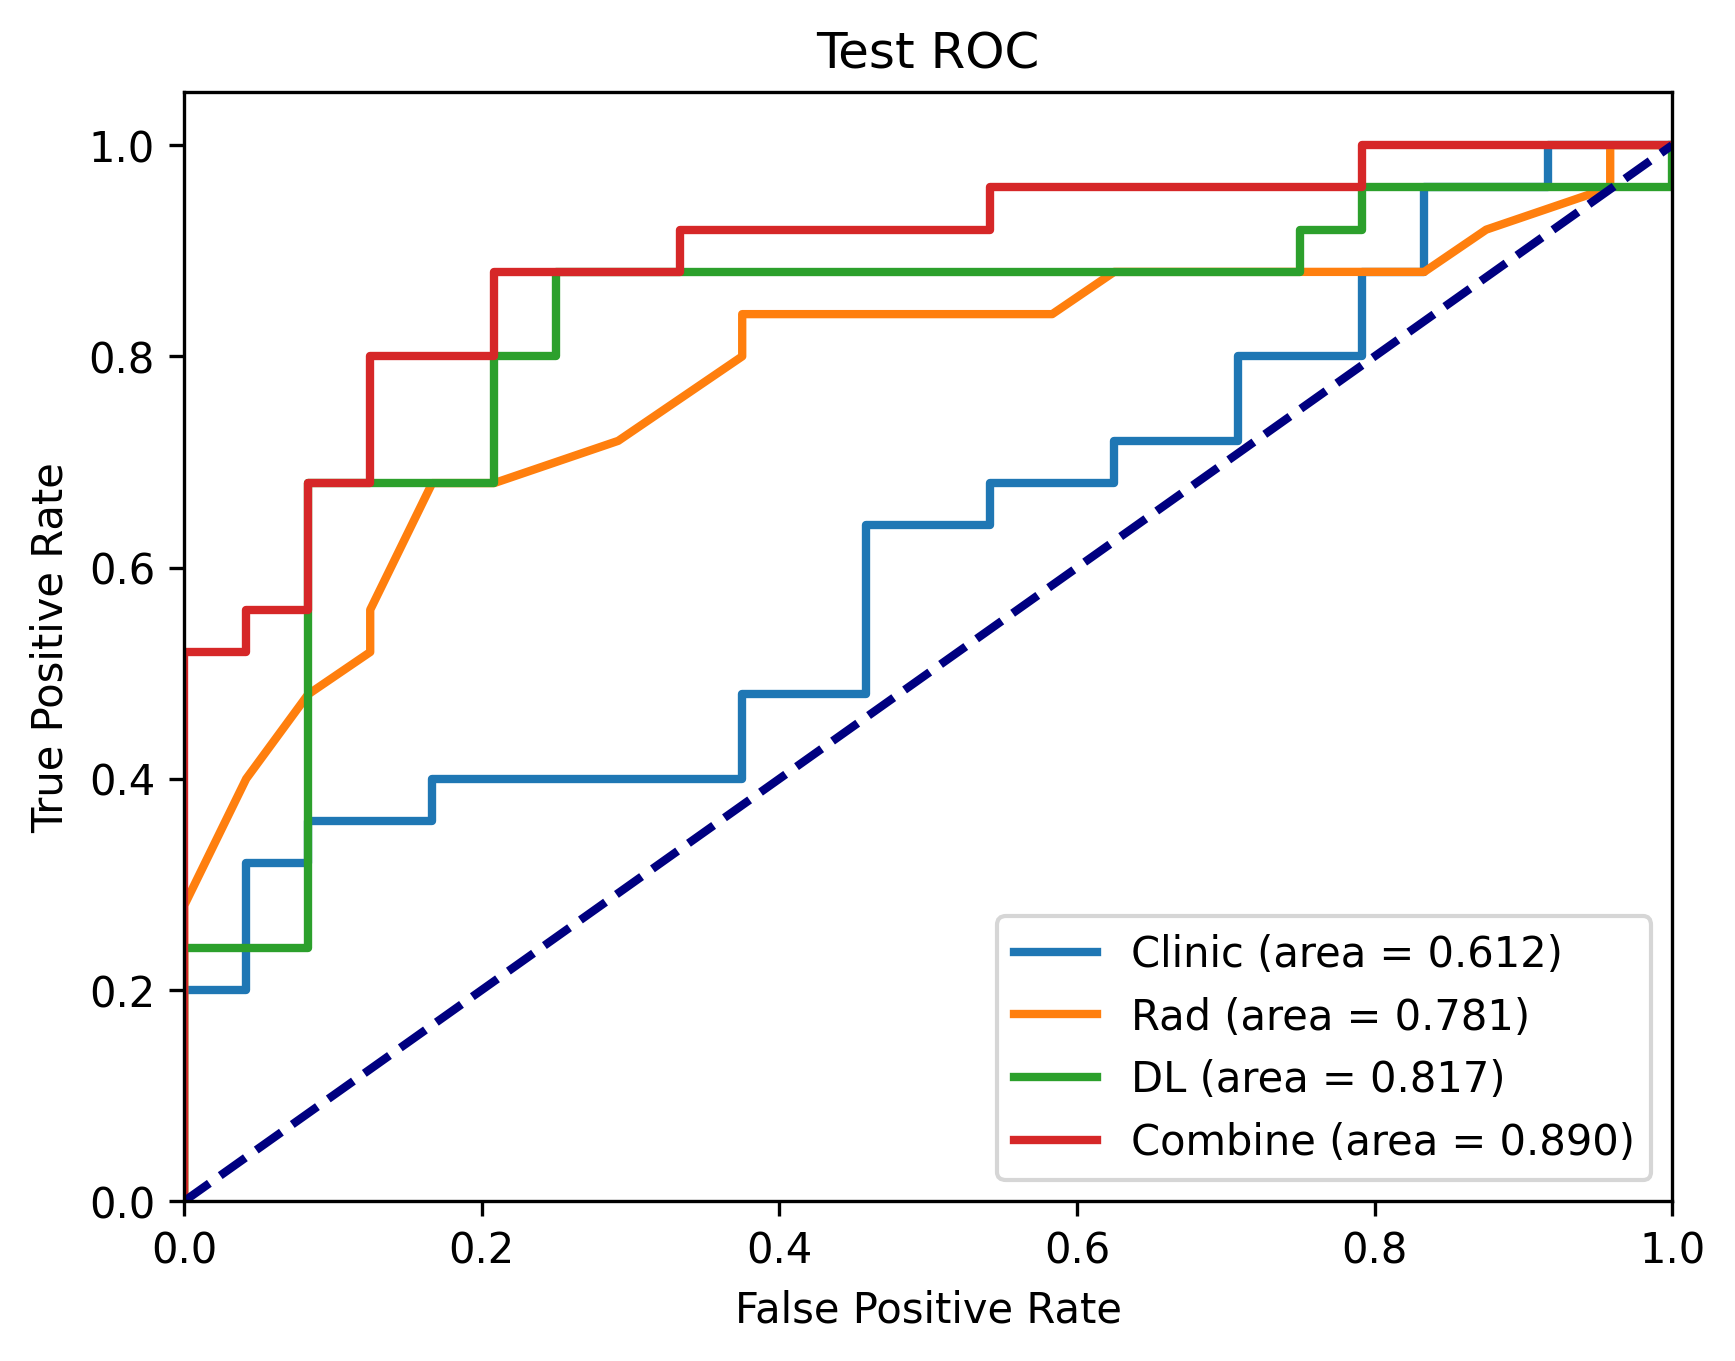

In [13]:
from pixelmed_calc.medical_imaging.Ploting.plot_metric import plot_multiple_ROCs
pred_scores_train = [pred_scores[model]['test'][:,1] for model in model_names]
y_test_arrays = [np.array(label_dict[model]['test']) for model in model_names]


plot_multiple_ROCs(y_test_arrays,pred_scores_train,models=model_names,title='Test ROC')
plt.savefig(f'results/test_roc.svg')
plt.show()



## delong检验

e-16 代码10的负16次方

In [14]:
from pixelmed_calc.medical_imaging.RadiologyComponents.delong import delong_roc_test
import numpy as np
# Define your models and dataset types
model_pairs = [
    ('Combine', 'Clinic'),
     ('Combine', 'Rad'),
      ('Combine', 'DL'),
]
dataset_types = ['train','test']

# Iterate through dataset types and model pairs to perform DeLong tests
for dataset_type in dataset_types:
    for model_one, model_two in model_pairs:
        ground_truth = np.array(label_dict[model_two][dataset_type])
        predictions_one = pred_scores[model_one][dataset_type][:, 1]
        predictions_two = pred_scores[model_two][dataset_type][:, 1]

        delong = delong_roc_test(ground_truth, predictions_one, predictions_two)
        print(f'delong检验-{dataset_type}集: {model_one} vs {model_two}，p值: {delong[0][0]}, z值: {delong[1][0]}')

delong检验-train集: Combine vs Clinic，p值: [4.60166812], z值: [-5.37766094]
delong检验-train集: Combine vs Rad，p值: [2.7510331], z值: [-2.2261577]
delong检验-train集: Combine vs DL，p值: [3.9449431], z值: [-4.09789409]
delong检验-test集: Combine vs Clinic，p值: [2.9982296], z值: [-2.56614538]
delong检验-test集: Combine vs Rad，p值: [1.65442826], z值: [-1.00859436]
delong检验-test集: Combine vs DL，p值: [1.41637289], z值: [-0.80502426]
